In [100]:
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.feature_extraction import FeatureHasher
from sklearn.feature_extraction.text import HashingVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [101]:
class readFile():
    def __init__(self, file, max_length = 1000000):
        self.file = file
        self.count = 0
        self.max_length = max_length
        
    def __iter__(self):
        if isinstance(self.file, str):
            self.file = [self.file]
        for f in self.file:
            for line in open(f, encoding='utf-8'):
                self.count += 1
                if self.count > self.max_length:
                    raise StopIteration()
                text = line.split('::')[1]
                yield text
            
def readLabel(file):
    y = []
    with open(file, encoding="utf-8") as f:
        tree = ET.parse(f)
        root = tree.getroot()
        for article in root.iter('article'):
            y.append(article.attrib['hyperpartisan'])
    return y

In [102]:
train_file = '../data/articles-training-bypublisher.txt'
dev_file = '../data/articles-validation-bypublisher.txt'
test_file = '../data/articles-training-byarticle.txt'

label_train = readLabel('../data/ground-truth-training-bypublisher.xml')
label_dev = readLabel('../data/ground-truth-validation-bypublisher.xml')
label_test = readLabel('../data/ground-truth-training-byarticle.xml')

In [103]:
#models.append(('NB', GaussianNB())) # NB cannot be used with sparse matrix
#models.append(('SVM', SVC()))

C = [0.1, 1, 10, 100]
lengths = [1000000] # to test whether more data really helps: generally yes
ngrams = [1,2,3]

result_trn = np.zeros((len(lengths), len(ngrams), len(C)))
result_dev = np.zeros((len(lengths), len(ngrams), len(C)))
for id_l, l in enumerate(lengths):
    # N-gram
    for id_n, n in enumerate(ngrams):
        vectorizer = HashingVectorizer(ngram_range=(1, n))
        corpus_train = readFile(train_file, l)
        corpus_dev = readFile(dev_file)
        trn = vectorizer.fit_transform(corpus_train)
        dev = vectorizer.transform(corpus_dev)
        for id_c, c in enumerate(C):
            print('Training for: length %i; ngrams %i; C %f' %(l,n,c))
            model = LogisticRegression(solver = 'lbfgs', C = c)
            model.fit(trn, label_train[:l])
            trn_pred = model.predict(trn) 
            result_trn[id_l, id_n, id_c] = accuracy_score(label_train[:l], trn_pred)
            dev_pred = model.predict(dev) 
            result_dev[id_l, id_n, id_c] = accuracy_score(label_dev, dev_pred)
            

Training for: length 1000000; ngrams 1; C 0.100000
Training for: length 1000000; ngrams 1; C 1.000000
Training for: length 1000000; ngrams 1; C 10.000000
Training for: length 1000000; ngrams 1; C 100.000000
Training for: length 1000000; ngrams 2; C 0.100000
Training for: length 1000000; ngrams 2; C 1.000000
Training for: length 1000000; ngrams 2; C 10.000000
Training for: length 1000000; ngrams 2; C 100.000000
Training for: length 1000000; ngrams 3; C 0.100000
Training for: length 1000000; ngrams 3; C 1.000000
Training for: length 1000000; ngrams 3; C 10.000000
Training for: length 1000000; ngrams 3; C 100.000000


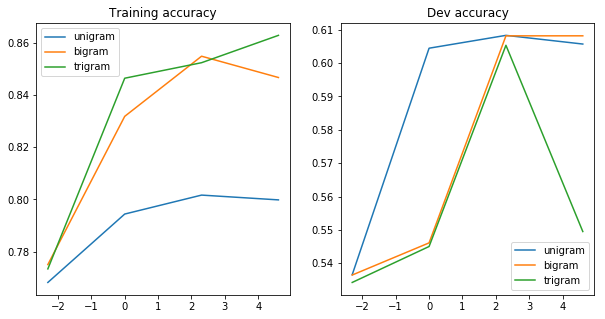

In [107]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]

plt.subplot(121)
for i in range(3):
    plt.plot(np.log(C), result_trn[0,i,:])
plt.title('Training accuracy')
plt.legend(['unigram', 'bigram', 'trigram'])
  
plt.subplot(122)
for i in range(3):
    plt.plot(np.log(C), result_dev[0,i,:])
plt.title('Dev accuracy')
plt.legend(['unigram', 'bigram', 'trigram'])
    
plt.show()

In [110]:
best_param =  np.unravel_index(np.argmax(result_dev), result_dev.shape)
print('Best for Dev: ', best_param)
print('Best for training:' ,np.unravel_index(np.argmax(result_trn), result_trn.shape))

Best for Dev:  (0, 0, 2)
Best for training: (0, 2, 3)


In [113]:
# Test on held-out testset
best_param =  np.unravel_index(np.argmax(result_dev), result_dev.shape)
corpus_train = readFile([train_file, dev_file])
corpus_test = readFile(test_file)
vectorizer = HashingVectorizer(ngram_range=(1, ngrams[best_param[1]]), stop_words=)
trn = vectorizer.fit_transform(corpus_train)
tst = vectorizer.transform(corpus_test)
model = LogisticRegression(solver = 'lbfgs', C=C[best_param[2]])
label_train.extend(label_dev)
model.fit(trn, label_train)
tst_pred = model.predict(tst)
print('Test accuracy: ', accuracy_score(label_test, tst_pred))
confusion_matrix(label_test, tst_pred)

Test accuracy:  0.5395348837209303


array([[138, 269],
       [ 28, 210]], dtype=int64)

In [115]:
from nltk.corpus import stopwords

best_param =  np.unravel_index(np.argmax(result_dev), result_dev.shape)
corpus_train = readFile([train_file, dev_file])
corpus_test = readFile(test_file)
vectorizer = HashingVectorizer(ngram_range=(1, ngrams[best_param[1]]), stop_words=stopwords.words('english'))
trn = vectorizer.fit_transform(corpus_train)
tst = vectorizer.transform(corpus_test)
model = LogisticRegression(solver = 'lbfgs', C=C[best_param[2]])
#label_train.extend(label_dev)
model.fit(trn, label_train)
tst_pred = model.predict(tst)
print('Test accuracy: ', accuracy_score(label_test, tst_pred))
confusion_matrix(label_test, tst_pred)

Test accuracy:  0.5426356589147286


array([[149, 258],
       [ 37, 201]], dtype=int64)